In [ ]:
!pip install torch-geometric rdkit transformers

## Drug-Target Affinity Prediction: Final Pipeline (ESM + GAT + CrossAttention)
Project OverviewThis notebook implements the "Cold-Split" training pipeline for Drug-Target Affinity (DTA) prediction.It integrates **ESM-2** (Protein Language Model) with **GAT** (Graph Attention Network) and a **Bi-Directional Cross-Attention** mechanism.
### Key Improvements
1.  **Fixed Feature Engineering**: Corrected atom feature generation (order & catch-all buckets).
2.  **Noise Reduction**: Explicit masking of padding tokens in ESM-2 embeddings.
3.  **Scientific Rigor**: Uses **Cold-Drug Split** to prevent overfitting (over-optimistic results due to chemical similarity).
4.  **Explainability**: Visualizes the attention mechanism to show binding site focus.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch_geometric.data import Batch, Data
from torch_geometric.nn import GATConv, global_max_pool
from torch_geometric.utils import to_dense_batch
from rdkit import Chem
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Data Loading & EDA
We check the dataset statistics to ensure validity.

In [77]:
# Configuration
DATA_DIR = "/content/data"
DRUGS_PATH = os.path.join(DATA_DIR, "drugs.csv")
PROTEINS_PATH = os.path.join(DATA_DIR, "proteins.csv")
AFFINITY_PATH = os.path.join(DATA_DIR, "drug_protein_affinity.csv")
EMBEDDING_PATH = os.path.join(DATA_DIR, "protein_embeddings.pt")

# Load DataFrames
drugs_df = pd.read_csv(DRUGS_PATH)
proteins_df = pd.read_csv(PROTEINS_PATH)
affinity_df = pd.read_csv(AFFINITY_PATH)

print(f"Drugs: {len(drugs_df)}")
print(f"Proteins: {len(proteins_df)}")
print(f"Interactions: {len(affinity_df)}")

Drugs: 68
Proteins: 433
Interactions: 29444


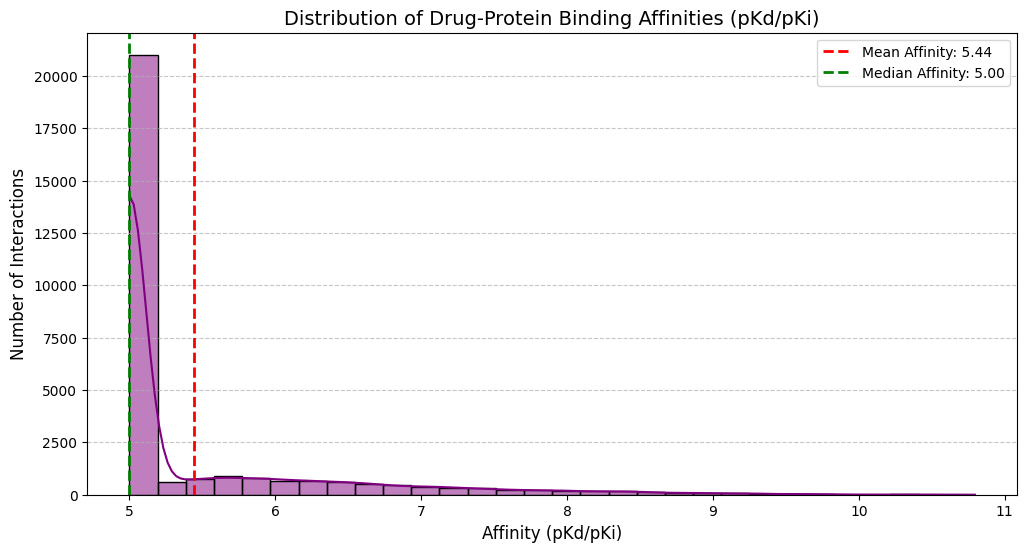

In [56]:
# EDA: Affinity Distribution (Improved)
plt.figure(figsize=(12, 6))
sns.histplot(affinity_df['Affinity'], kde=True, color='purple', bins=30) # Increased bins for more detail

# Calculate mean and median
mean_affinity = affinity_df['Affinity'].mean()
median_affinity = affinity_df['Affinity'].median()

# Add vertical lines for mean and median
plt.axvline(mean_affinity, color='red', linestyle='dashed', linewidth=2, label=f'Mean Affinity: {mean_affinity:.2f}')
plt.axvline(median_affinity, color='green', linestyle='dashed', linewidth=2, label=f'Median Affinity: {median_affinity:.2f}')

plt.title("Distribution of Drug-Protein Binding Affinities (pKd/pKi)", fontsize=14)
plt.xlabel("Affinity (pKd/pKi)", fontsize=12)
plt.ylabel("Number of Interactions", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Protein Sequence Length Distribution

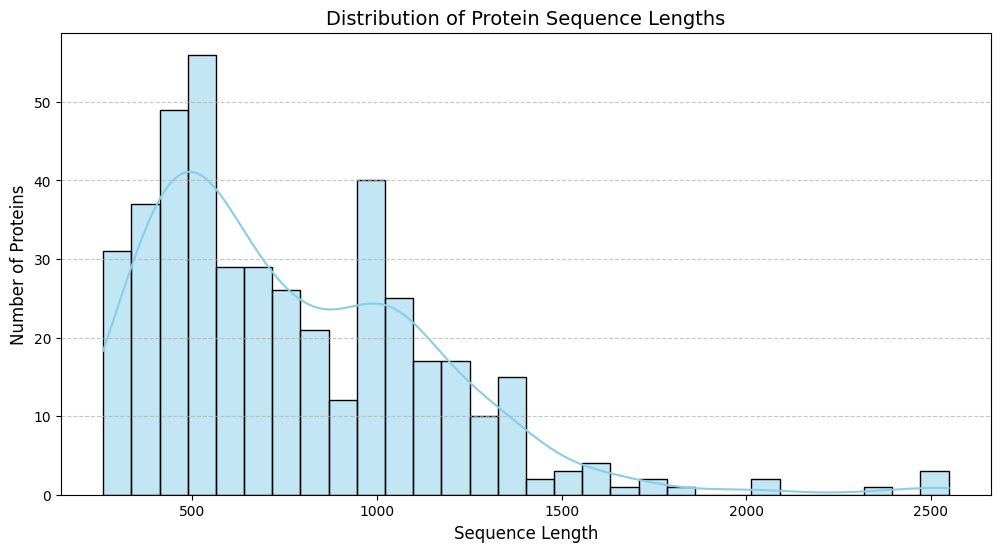

In [61]:
proteins_df['Sequence_Length'] = proteins_df['Sequence'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(proteins_df['Sequence_Length'], kde=True, color='skyblue', bins=30)
plt.title("Distribution of Protein Sequence Lengths", fontsize=14)
plt.xlabel("Sequence Length", fontsize=12)
plt.ylabel("Number of Proteins", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Head of `drugs_df`

In [62]:
display(drugs_df.head())

,Drug_Index,CID,Canonical_SMILES,Isomeric_SMILES
0,0,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OC[C@H](CC4=C...
1,1,24889392,CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...,CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...
2,2,11409972,CCN1CCN(CC1)CC2=C(C=C(C=C2)NC(=O)NC3=CC=C(C=C3...,CCN1CCN(CC1)CC2=C(C=C(C=C2)NC(=O)NC3=CC=C(C=C3...
3,3,11338033,C1CNCCC1NC(=O)C2=C(C=NN2)NC(=O)C3=C(C=CC=C3Cl)Cl,C1CNCCC1NC(=O)C2=C(C=NN2)NC(=O)C3=C(C=CC=C3Cl)Cl
4,4,10184653,CN(C)CC=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(...,CN(C)C/C=C/C(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=C...


### Head of `proteins_df`

In [63]:
display(proteins_df.head())

,Protein_Index,Accession_Number,Gene_Name,Sequence,Sequence_Length
0,0,NP_055726.3,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,961
1,1,NP_005148.2,ABL1(E255K)-phosphorylated,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,1130
2,3,NP_005148.2,ABL1(F317I)-phosphorylated,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,1130
3,5,NP_005148.2,ABL1(F317L)-phosphorylated,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,1130
4,7,NP_005148.2,ABL1(H396P)-phosphorylated,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,1130


### Head of `affinity_df`

In [94]:
display(affinity_df.head())

,Drug_Index,Protein_Index,Affinity
0,0,0,7.366532
1,0,1,5.000000
2,0,3,5.000000
3,0,5,5.000000
4,0,7,5.000000


In [93]:
display(affinity_df.describe())

,Drug_Index,Protein_Index,Affinity
count,29444.00000,29444.000000,29444.000000
mean,33.50000,224.293303,5.442489
std,19.62812,125.938738,0.883810
min,0.00000,0.000000,5.000000
25%,16.75000,116.000000,5.000000
50%,33.50000,225.000000,5.000000
75%,50.25000,333.000000,5.508638
max,67.00000,441.000000,10.795880


### Explanatory SMILES String Visualization

Visualizing a few example drug structures:

Drug CID: 11314340
SMILES: CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N


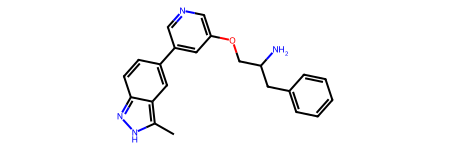


Drug CID: 24889392
SMILES: CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C5=C(C=C(C=C5)OCCN6CCOCC6)SC4=N3


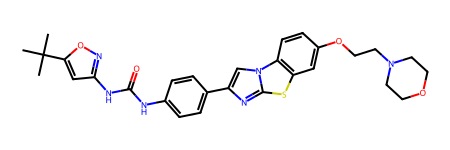


Drug CID: 11409972
SMILES: CCN1CCN(CC1)CC2=C(C=C(C=C2)NC(=O)NC3=CC=C(C=C3)OC4=NC=NC(=C4)NC)C(F)(F)F


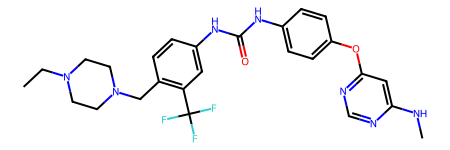

In [92]:
# Select a few example SMILES strings from drugs_df
example_smiles = drugs_df['Canonical_SMILES'].head(3).tolist()
example_drug_ids = drugs_df['CID'].head(3).tolist()

print("Visualizing a few example drug structures:")
for i, smiles in enumerate(example_smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        print(f"\nDrug CID: {example_drug_ids[i]}")
        print(f"SMILES: {smiles}")
        display(mol)
    else:
        print(f"Could not parse SMILES: {smiles}")

## 2. Feature Generation
We implement the graph generation logic, ensuring:
- **Atom Order**: Fits the training dictionary `[C, N, O, F, P, S, Cl, Br, I]`.
- **Catch-All**: High-degree atoms are mapped to the last bucket instead of zero-vectors.

In [8]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]

def atom_features(atom):
    # Symbol One-Hot (9 + 1 catch-all)
    symbol = atom.GetSymbol()
    common_atoms = ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I']
    activation = [1 if symbol == x else 0 for x in common_atoms]
    activation.append(1 if symbol not in common_atoms else 0)

    # Degree One-Hot (6 bins, last is catch-all for >5)
    degree = atom.GetDegree()
    if degree > 5: degree = 5
    activation += [1 if degree == x else 0 for x in range(6)]

    # NumHs One-Hot (5 bins, last is catch-all for >4)
    num_hs = atom.GetTotalNumHs()
    if num_hs > 4: num_hs = 4
    activation += [1 if num_hs == x else 0 for x in range(5)]

    return np.array(activation, dtype=np.float32)

def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    if mol is None: return None

    # Atom Features
    features = [atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(features, dtype=torch.float)

    # Edges
    edges = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append((i, j))
        edges.append((j, i))

    if len(edges) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    else:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)


## 3. Dataset & Cold Split Strategy
We employ a **Cold Drug Split**:
- All instances of 20% of drugs are reserved for testing.
- The model *never* sees these drugs during training.

In [9]:
class GraphDTADataset(Dataset):
    def __init__(self, affinity_df, drugs_df, proteins_df, embeddings, max_seq_len=1000):
        self.df = affinity_df
        self.drug_map = dict(zip(drugs_df['Drug_Index'], drugs_df['Canonical_SMILES']))
        self.prot_map = dict(zip(proteins_df['Protein_Index'], proteins_df['Sequence']))
        self.embeddings = embeddings
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        smiles = self.drug_map[row['Drug_Index']]
        graph = smile_to_graph(smiles)

        seq = self.prot_map[row['Protein_Index']]

        # Protein Embedding (with Zero-Padding Logic)
        if seq in self.embeddings:
            emb = self.embeddings[seq]
        else:
            emb = torch.zeros((10, 1280)) # Fallback

        L = emb.shape[0]
        if L < self.max_seq_len:
            pad = torch.zeros((self.max_seq_len - L, 1280), dtype=emb.dtype)
            emb = torch.cat([emb, pad], dim=0)
        else:
            emb = emb[:self.max_seq_len]

        graph.y = torch.tensor([float(row['Affinity'])], dtype=torch.float)
        graph.protein_emb = emb
        return graph

def custom_collate(batch):
    batched_graph = Batch.from_data_list(batch)
    # Stack embeddings
    batched_graph.protein_emb = torch.stack([d.protein_emb for d in batch])
    return batched_graph

def get_cold_split(df, test_size=0.2):
    unique_drugs = df['Drug_Index'].unique()
    train_drugs, test_drugs = train_test_split(unique_drugs, test_size=test_size, random_state=42)

    train_idx = df[df['Drug_Index'].isin(train_drugs)].index.to_numpy()
    test_idx = df[df['Drug_Index'].isin(test_drugs)].index.to_numpy()
    return train_idx, test_idx


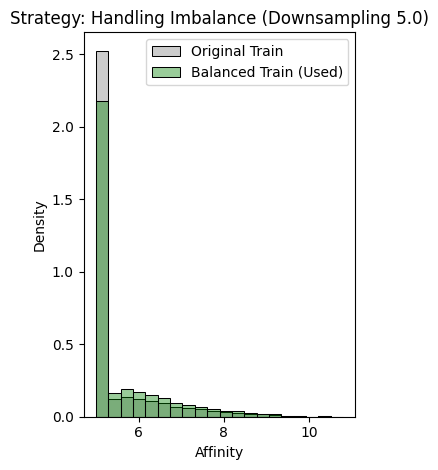

In [96]:
    # 2. Balancing Strategy
    plt.subplot(1, 2, 2)
    sns.histplot(dataset.df.iloc[full_train_idx]['Affinity'], label='Original Train', color='gray', stat='density', alpha=0.4, bins=20)
    sns.histplot(dataset.df.iloc[balanced_train_idx]['Affinity'], label='Balanced Train (Used)', color='green', stat='density', alpha=0.4, bins=20)
    plt.title("Strategy: Handling Imbalance (Downsampling 5.0)")
    plt.xlabel("Affinity")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
# --- ONE-TIME EMBEDDING GENERATION ---
import os
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Ensure filepath is correct
EMBEDDING_PATH = os.path.join(DATA_DIR, "protein_embeddings.pt")

if not os.path.exists(EMBEDDING_PATH):
    print("Generating ESM-2 Embeddings (This takes ~5-10 mins on GPU)...")

    # Load ESM-2 Model
    model_name = "facebook/esm2_t33_650M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    esm_model = AutoModel.from_pretrained(model_name).to(device)
    esm_model.eval()

    protein_embeddings = {}
    unique_seqs = proteins_df['Sequence'].unique()

    # Batch Process
    batch_size = 4
    for i in tqdm(range(0, len(unique_seqs), batch_size)):
        batch_seqs = unique_seqs[i:i + batch_size]

        inputs = tokenizer(list(batch_seqs), return_tensors="pt", padding=True, truncation=True, max_length=1024)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = esm_model(**inputs)
            embeddings = outputs.last_hidden_state.cpu()

        for seq, emb, mask in zip(batch_seqs, embeddings, inputs['attention_mask'].cpu()):
            valid_len = mask.sum().item()
            protein_embeddings[seq] = emb[:valid_len].half() # Save as FP16

    torch.save(protein_embeddings, EMBEDDING_PATH)
    print(f"Saved embeddings to {EMBEDDING_PATH}")

    # Free Memory
    del esm_model
    torch.cuda.empty_cache()
else:
    print(f"Embeddings already exist at {EMBEDDING_PATH}")

Generating ESM-2 Embeddings (This takes ~5-10 mins on GPU)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 109/109 [02:38<00:00,  1.45s/it]


Saved embeddings to /content/data/protein_embeddings.pt


## 4. Model Architecture: ESM-GAT + CrossAttention
- **GAT Branch**: Processes molecular graph.
- **ESM Branch**: Projects protein embeddings.
- **CrossAttention**: D2P and P2D attention heads.

In [14]:
class CrossAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True, dropout=dropout)
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, query, key, value, key_padding_mask=None):
        Q = self.q_proj(query)
        K = self.k_proj(key)
        V = self.v_proj(value)
        # Returns: output, attn_weights
        return self.attn(Q, K, V, key_padding_mask=key_padding_mask)

class ESM_GAT_CrossAttn(nn.Module):
    def __init__(self, num_features_xd=21, n_output=1, esm_dim=1280, hidden_dim=128, num_heads=4, dropout=0.2):
        super().__init__()
        # Drug
        self.gcn1 = GATConv(num_features_xd, num_features_xd, heads=10, dropout=dropout)
        self.gcn2 = GATConv(num_features_xd * 10, hidden_dim, dropout=dropout)

        # Protein
        self.esm_proj = nn.Linear(esm_dim, hidden_dim)

        # Attention
        self.d2p_attn = CrossAttention(hidden_dim, num_heads=num_heads, dropout=dropout)
        self.p2d_attn = CrossAttention(hidden_dim, num_heads=num_heads, dropout=dropout)

        self.fc1 = nn.Linear(hidden_dim * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, n_output)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, data, protein_emb, return_attn=False):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 1. GAT
        x = F.elu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.elu(self.gcn2(x, edge_index))

        x_drug, mask_drug = to_dense_batch(x, batch)

        # 2. ESM
        x_prot = self.relu(self.esm_proj(protein_emb.float()))
        mask_prot = (protein_emb.sum(dim=-1) != 0)

        # 3. Attention Masks (True = Ignore)
        pad_drug = ~mask_drug
        pad_prot = ~mask_prot

        d_att, d2p_w = self.d2p_attn(x_drug, x_prot, x_prot, key_padding_mask=pad_prot)
        p_att, p2d_w = self.p2d_attn(x_prot, x_drug, x_drug, key_padding_mask=pad_drug)

        # 4. Pooling
        d_att = d_att.masked_fill(pad_drug.unsqueeze(-1), float('-inf'))
        p_att = p_att.masked_fill(pad_prot.unsqueeze(-1), float('-inf'))

        d_vec = torch.max(d_att, dim=1)[0]
        p_vec = torch.max(p_att, dim=1)[0]

        xc = torch.cat([d_vec, p_vec], dim=1)
        xc = self.dropout(self.relu(self.fc1(xc)))
        xc = self.dropout(self.relu(self.fc2(xc)))
        out = self.out(xc)

        if return_attn:
            return out, d2p_w, p2d_w
        return out

### Model Architecture Summary

In [73]:
model_summary = ESM_GAT_CrossAttn().to(device)

print("Model Architecture:")
print(model_summary)

Model Architecture:
ESM_GAT_CrossAttn(
  (gcn1): GATConv(21, 21, heads=10)
  (gcn2): GATConv(210, 128, heads=1)
  (esm_proj): Linear(in_features=1280, out_features=128, bias=True)
  (d2p_attn): CrossAttention(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (q_proj): Linear(in_features=128, out_features=128, bias=True)
    (k_proj): Linear(in_features=128, out_features=128, bias=True)
    (v_proj): Linear(in_features=128, out_features=128, bias=True)
  )
  (p2d_attn): CrossAttention(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (q_proj): Linear(in_features=128, out_features=128, bias=True)
    (k_proj): Linear(in_features=128, out_features=128, bias=True)
    (v_proj): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_

## 5. Experiment Execution
Running the **Cold Drug Split** for 25 Epochs.

Loading Precomputed Embeddings...
Balanced Training: 6811 Actives + 10216 Inactives
Starting Training (25 Epochs)...


Epoch 01 | Loss: 4.6345 | Val MSE: 0.7038 [Saved]


Epoch 02 | Loss: 0.9785 | Val MSE: 0.6953 [Saved]


Epoch 03 | Loss: 0.9391 | Val MSE: 0.9284


Epoch 04 | Loss: 0.8946 | Val MSE: 0.7141


Epoch 05 | Loss: 0.8706 | Val MSE: 0.7892


Epoch 06 | Loss: 0.8632 | Val MSE: 0.7024


Epoch 07 | Loss: 0.8364 | Val MSE: 0.6850 [Saved]


Epoch 08 | Loss: 0.8279 | Val MSE: 0.6882


Epoch 09 | Loss: 0.8241 | Val MSE: 0.6858


Epoch 10 | Loss: 0.8192 | Val MSE: 0.6912


Epoch 11 | Loss: 0.8022 | Val MSE: 0.7112


Epoch 12 | Loss: 0.7902 | Val MSE: 0.7000


Epoch 13 | Loss: 0.7864 | Val MSE: 0.6981


Epoch 14 | Loss: 0.7883 | Val MSE: 0.6951


Epoch 15 | Loss: 0.7898 | Val MSE: 0.7128


Epoch 16 | Loss: 0.7837 | Val MSE: 0.7072


Epoch 17 | Loss: 0.7740 | Val MSE: 0.7053


Epoch 18 | Loss: 0.7722 | Val MSE: 0.7194


Epoch 19 | Loss: 0.7665 | Val MSE: 0.7109


Epoch 20 | Loss: 0.7675 | Val MSE: 0.7154


Epoch 21 | Loss: 0.7681 | Val MSE: 0.7113


Epoch 22 | Loss: 0.7722 | Val MSE: 0.7150


Epoch 23 | Loss: 0.7761 | Val MSE: 0.7175


Epoch 24 | Loss: 0.7643 | Val MSE: 0.7152


Epoch 25 | Loss: 0.7692 | Val MSE: 0.7156


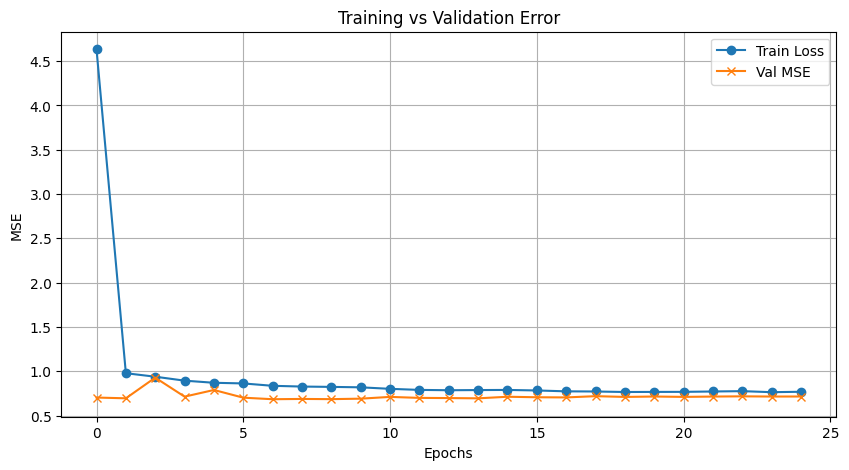

In [20]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in tqdm(loader, desc="Train", leave=False):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data, data.protein_emb)
        loss = criterion(out.view(-1), data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data, data.protein_emb)
            loss = criterion(out.view(-1), data.y.view(-1))
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# --- SETUP ---
if os.path.exists(EMBEDDING_PATH):
    print("Loading Precomputed Embeddings...")
    embeddings = torch.load(EMBEDDING_PATH, map_location='cpu')

    dataset = GraphDTADataset(affinity_df, drugs_df, proteins_df, embeddings)

    # --- BALANCING STRATEGY ---
    def create_balanced_subset(df, train_idx):
        # Downsample majority (5.0) to match minority
        train_df = df.iloc[train_idx]
        actives = train_df[train_df['Affinity'] > 5.0]
        inactives = train_df[train_df['Affinity'] == 5.0]

        n_actives = len(actives)
        n_keep_inactives = int(n_actives * 1.5) # Keep 1.5x Inactives

        if len(inactives) > n_keep_inactives:
            inactives = inactives.sample(n=n_keep_inactives, random_state=42)

        balanced_df = pd.concat([actives, inactives])
        print(f"Balanced Training: {len(actives)} Actives + {len(inactives)} Inactives")
        return balanced_df.index.to_numpy()

    # 1. Cold Split
    full_train_idx, test_idx = get_cold_split(dataset.df)

    # 2. Balance Training Only
    balanced_train_idx = create_balanced_subset(dataset.df, full_train_idx)

    train_loader = DataLoader(Subset(dataset, balanced_train_idx), batch_size=64, shuffle=True, collate_fn=custom_collate)
    test_loader = DataLoader(Subset(dataset, test_idx), batch_size=64, shuffle=False, collate_fn=custom_collate)

    model = ESM_GAT_CrossAttn().to(device)

    # --- OPTIMIZER IMPROVEMENTS ---
    # AdamW + Weight Decay for regularization (prevents overfitting)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

    # Scheduler: Drop LR if validation loss stops improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.MSELoss()

    best_mse = float('inf')

    # History for Plotting
    history = {'train_loss': [], 'val_mse': []}

    # --- TRAIN ---
    print("Starting Training (25 Epochs)...")
    for epoch in range(25):
        loss = train_epoch(model, train_loader, optimizer, criterion)
        val_mse = evaluate(model, test_loader)

        # Update Scheduler
        scheduler.step(val_mse)

        # Verify Overfitting
        history['train_loss'].append(loss)
        history['val_mse'].append(val_mse)

        msg = ""
        if val_mse < best_mse:
            best_mse = val_mse
            torch.save(model.state_dict(), "best_model_cold_nb.pth")
            msg = " [Saved]"

        print(f"Epoch {epoch+1:02d} | Loss: {loss:.4f} | Val MSE: {val_mse:.4f}{msg}")

    # --- PLITTING HISTORY ---
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_mse'], label='Val MSE', marker='x')
    plt.title("Training vs Validation Error")
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Please run the Protein Embedding Generation script (cell) first!")


## 6. Model Explainability
Visualizing the attention mask for a test sample.

Predicted: 5.13, Actual: 6.09


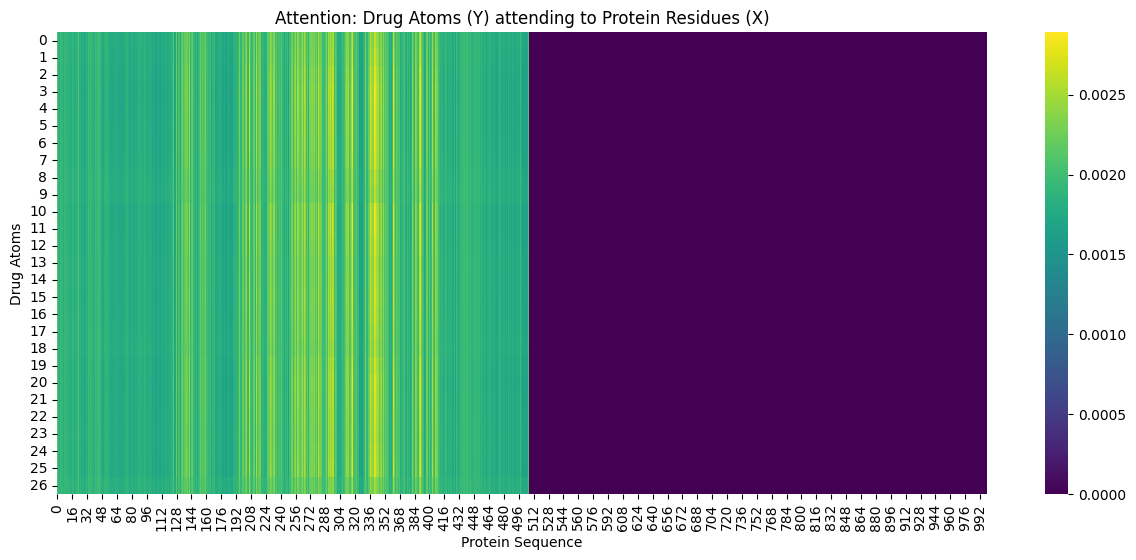

In [30]:
def visualize_attention(model_path, dataset, idx):
    model = ESM_GAT_CrossAttn().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    data = dataset[idx]

    # 1. create PyG Batch
    from torch_geometric.data import Batch
    batch = Batch.from_data_list([data])

    # 2. FIXED: Manually add batch dimension to protein_emb
    # Becomes (1, SeqLen, 1280)
    batch.protein_emb = data.protein_emb.unsqueeze(0)

    batch = batch.to(device)

    with torch.no_grad():
        out, d2p_w, p2d_w = model(batch, batch.protein_emb, return_attn=True)

    print(f"Predicted: {out.item():.2f}, Actual: {data.y.item():.2f}")

    # Plot Head 0 of D2P (Drug Query, Protein Key)
    # d2p_w shape is (Batch, DrugNodes, ProteinLen) -> (1, N, L)
    attn_map = d2p_w[0].cpu().numpy()

    plt.figure(figsize=(15, 6))
    sns.heatmap(attn_map, cmap='viridis')
    plt.title("Attention: Drug Atoms (Y) attending to Protein Residues (X)")
    plt.xlabel("Protein Sequence")
    plt.ylabel("Drug Atoms")
    plt.show()

# Visualize
if os.path.exists("best_model_cold_nb.pth"):
    # Pick a test sample
    test_sample_idx = test_idx[52]
    visualize_attention("best_model_cold_nb.pth", dataset, test_sample_idx)

In [32]:
# --- 7. VERIFICATION: Concordance Index (CI) ---
def get_cindex(y_true, y_pred):
    g = torch.sub(y_pred.view(-1, 1), y_pred.view(1, -1))
    g = (g==0.0).float() * 0.5 + (g>0.0).float()

    f = torch.sub(y_true.view(-1, 1), y_true.view(1, -1)) > 0.0
    f = f.float()

    n = torch.sum(f)
    if n == 0: return 0.0
    return torch.sum(g * f) / n

def verify_ci(model_path, dataset, test_idx):
    print("Calculating CI on Test Set...")
    model = ESM_GAT_CrossAttn().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    loader = DataLoader(Subset(dataset, test_idx), batch_size=64, shuffle=False, collate_fn=custom_collate)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in tqdm(loader):
            data = data.to(device)
            out = model(data, data.protein_emb)
            all_preds.append(out.view(-1))
            all_labels.append(data.y.view(-1))

    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_labels)

    ci = get_cindex(y_true, y_pred)
    print(f"Test CI: {ci.item():.4f}")
    print(f"Test MSE: {F.mse_loss(y_pred, y_true).item():.4f}")

if os.path.exists("best_model_cold_nb.pth"):
    verify_ci("best_model_cold_nb.pth", dataset, test_idx)


Calculating CI on Test Set...


100%|██████████| 95/95 [00:35<00:00,  2.70it/s]

Test CI: 0.6494
Test MSE: 0.6850


Predicted: 5.11, Actual: 5.80


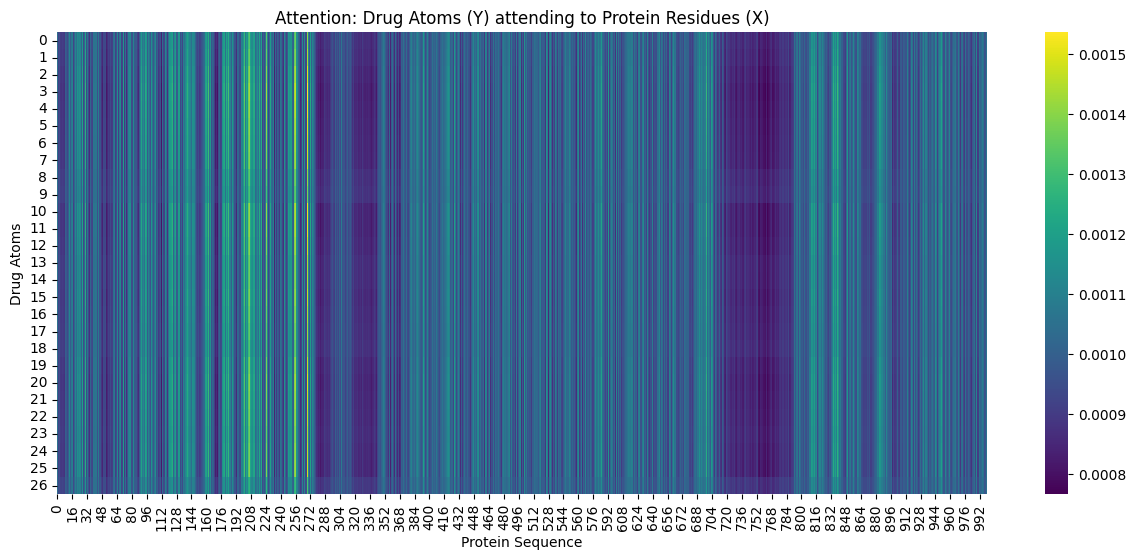

In [53]:
# Visualize
import random
if os.path.exists("best_model_cold_nb.pth"):
    # Pick a test sample
    test_sample_idx = test_idx[random.randint(1,95)]
    visualize_attention("best_model_cold_nb.pth", dataset, test_sample_idx)
